# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats

import matplotlib.pyplot as plt

In [ ]:
base_path = "/content/drive/MyDrive"
X = pd.read_csv(f'{base_path}/X_train.csv')
y: pd.Series = pd.read_csv(f'{base_path}/y_train.csv').squeeze()

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

X_test_1 = pd.read_csv(f'{base_path}/X_test_1.csv')
X_test_2 = pd.read_csv(f'{base_path}/X_test_2.csv')
X_test_2_labelled = X_test_2[:202]
y_test_2_labelled: pd.Series = pd.read_csv(f'{base_path}/y_test_2_reduced.csv').squeeze()

In [ ]:
print(np.unique(y), y.shape)
print(np.unique(y_test_2_labelled), y_test_2_labelled.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] (10000,)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 23 24 25 26 27] (202,)


# Simple comparisons

Comparing the marginal distributions of class labels between source (training) and target (deployment) data

In [ ]:
source_labels_marginalised = np.bincount(y) / np.bincount(y).sum()
np.bincount(y), source_labels_marginalised, 4479 / 10000
print(source_labels_marginalised, )

[0.0018 0.0007 0.0007 0.0065 0.0238 0.4479 0.0553 0.0103 0.0516 0.0025
 0.1081 0.0078 0.0457 0.0062 0.0264 0.0026 0.0006 0.0354 0.006  0.0177
 0.0153 0.0269 0.0007 0.0041 0.0385 0.0184 0.0278 0.0107]


Histograms comparing the class distribution from training and deployment

In [ ]:
def get_marginal_y(y):
    return y.value_counts() / y.value_counts().sum()

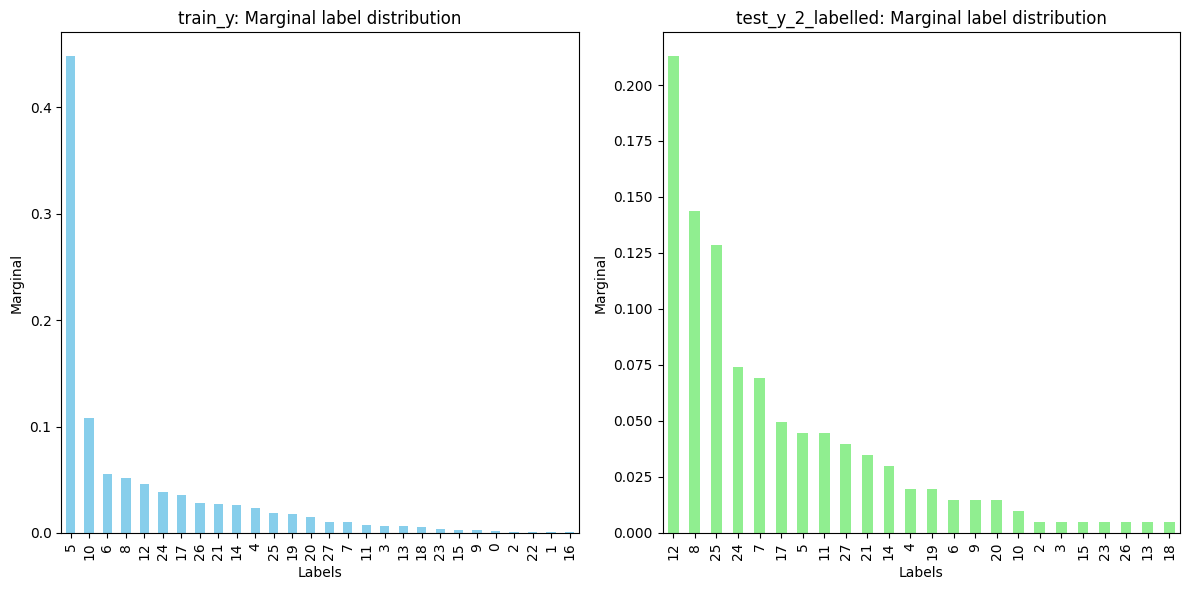

In [ ]:
def show_sorted_class_dist_histogram():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    get_marginal_y(y).plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('train_y: Marginal label distribution')
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Marginal')

    get_marginal_y(y_test_2_labelled).plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('test_y_2_labelled: Marginal label distribution')
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Marginal')

    plt.tight_layout()
    plt.show()

show_sorted_class_dist_histogram()

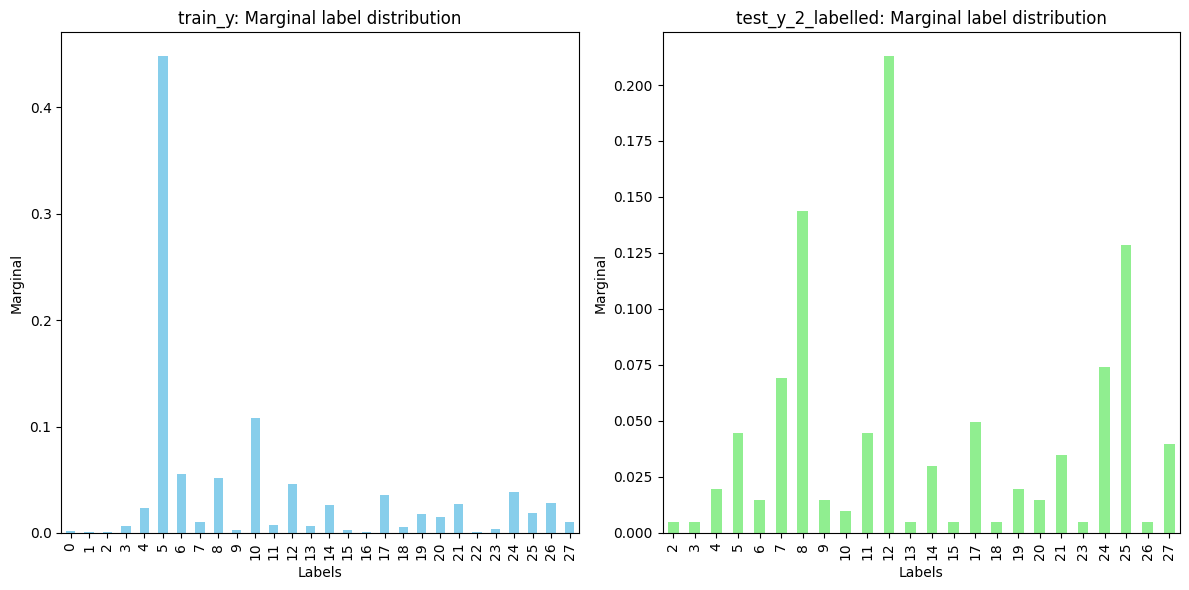

In [ ]:
def show_class_dist_histogram():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    get_marginal_y(y).sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('train_y: Marginal label distribution')
    axes[0].set_xlabel('Labels')
    axes[0].set_ylabel('Marginal')

    get_marginal_y(y_test_2_labelled).sort_index().plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('test_y_2_labelled: Marginal label distribution')
    axes[1].set_xlabel('Labels')
    axes[1].set_ylabel('Marginal')

    plt.tight_layout()
    plt.show()

show_class_dist_histogram()

We start with simple histograms of the training and labelled deployment class labels. They clearly show differences in label frequencies and that some labels present in the training set are missing in the labeled part of test set 2, strongly suggesting label shift.

# KS Test  

Evaluating the distribution shifts between the combined dataset (train_X + test_X_1) and test_X_2.

A larger KS statistic is indicative of a larger shift in distribution.

In [ ]:
def evaluate_distribution_shift(df1: pd.DataFrame, df2: pd.DataFrame):
    ks_statistics = []
    for column in df1.columns:
        stat, _ = stats.ks_2samp(df1[column], df2[column])
        ks_statistics.append({'feature': column, 'ks_statistic': stat})
    ks_df = pd.DataFrame(ks_statistics).sort_values(by='ks_statistic', ascending=False)
    return ks_df

In [ ]:
combined_train_test_X_1 = pd.concat([X, X_test_1])

ks_results_combined_train_test = evaluate_distribution_shift(combined_train_test_X_1, X_test_2_labelled)
ks_results_combined_train_test

,feature,ks_statistic
249,249,0.343013
90,90,0.337245
141,141,0.308724
46,46,0.300582
270,270,0.289607
...,...,...
1,1,0.038434
183,183,0.037032
256,256,0.036085
128,128,0.034688


In [ ]:
ks_results_train_only = evaluate_distribution_shift(X, X_test_2_labelled)
ks_results_train_only

,feature,ks_statistic
249,249,0.347976
90,90,0.341781
141,141,0.312378
46,46,0.303373
270,270,0.292970
...,...,...
275,275,0.037630
183,183,0.037441
256,256,0.035712
192,192,0.035173


In [ ]:
ks_results_test_only = evaluate_distribution_shift(X_test_1, X_test_2_labelled)
ks_results_test_only

,feature,ks_statistic
249,249,0.293376
90,90,0.291881
46,46,0.272673
141,141,0.272178
270,270,0.255970
...,...,...
244,244,0.039416
183,183,0.037931
4,4,0.037178
16,16,0.035426


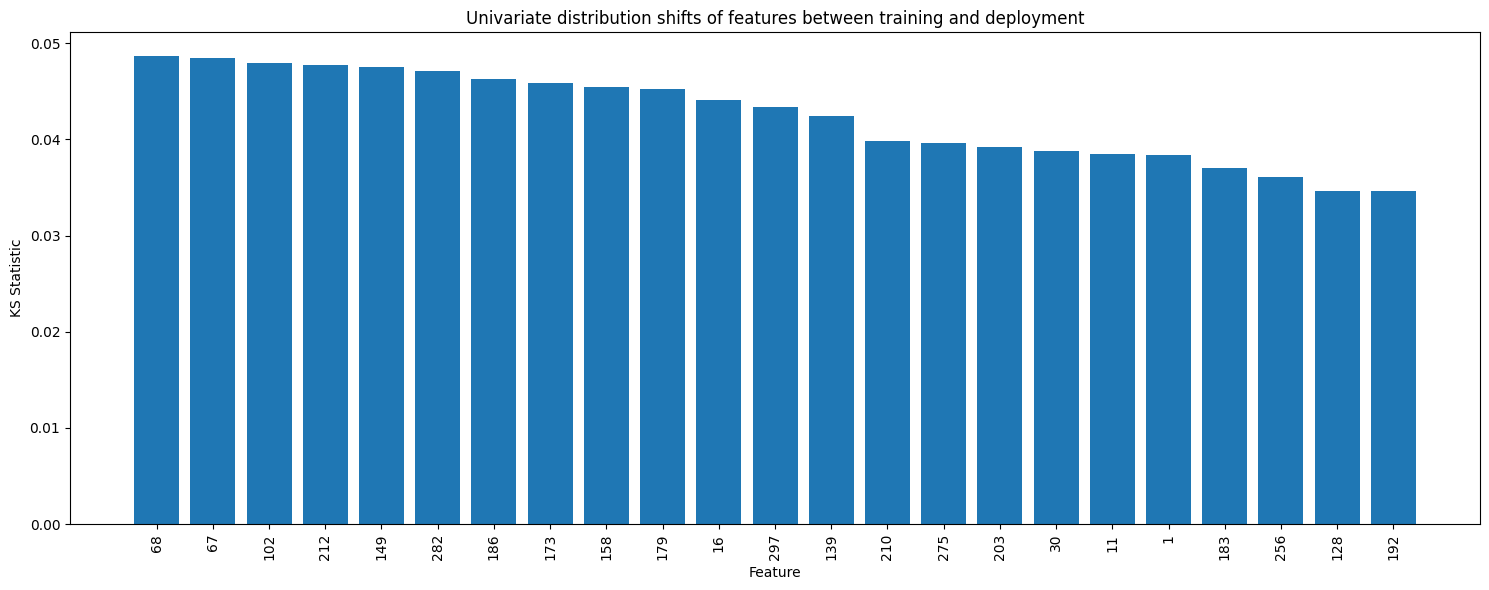

In [ ]:
def plot_features_from_diff_distrib(ks_results: pd.DataFrame):
    plt.figure(figsize=(15, 6))
    filtered = ks_results.loc[ks_results['ks_statistic'] < 0.05]
    plt.bar(filtered['feature'], filtered['ks_statistic'])
    plt.xlabel('Feature')
    plt.ylabel('KS Statistic')
    plt.title('Univariate distribution shifts of features between training and deployment')
    plt.xticks(ticks=range(len(filtered)), labels=filtered['feature'], rotation=90)
    plt.tight_layout()
    plt.show()

plot_features_from_diff_distrib(ks_results_combined_train_test)

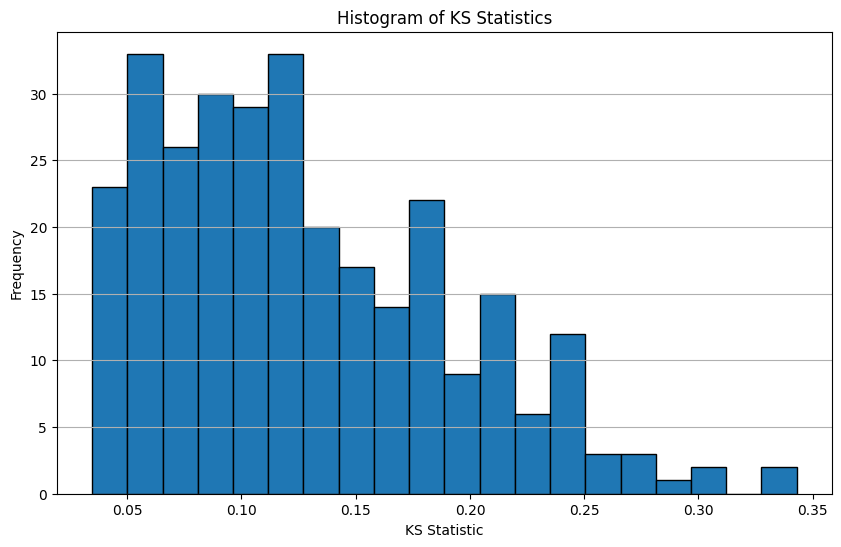

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ks_results_combined_train_test['ks_statistic'], bins=20, edgecolor='black')
plt.title('Histogram of KS Statistics')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Applying the 2-sample KS test feature-by-feature is a standard and statistically valid method for identifying univariate distribution shifts. The results, showing high KS statistics and many significant p-values (as implied by the plot filtering), provide strong evidence for covariate shift.

# Alibi Detect

Kolmogorov-Smirnov Test for Label Distribution Shift (y-values)

In [ ]:
!pip install alibi-detect[tensorflow]

In [ ]:
from sklearn.decomposition import PCA
from alibi_detect.cd import MMDDrift

MMD Test for checking the invariant of P(X|y) = Q(X|y) (label shift)

In [ ]:
unique_labels = np.unique(np.concatenate([y, y_test_2_labelled]))

X_source = X.to_numpy()
X_target = X_test_2_labelled.to_numpy()
Y_source = y.to_numpy()
Y_target = y_test_2_labelled.to_numpy()

In [ ]:
for y in unique_labels:
    X_source_y = X_source[Y_source == y]
    X_target_y = X_target[Y_target == y]

    if len(X_source_y) < 2 or len(X_target_y) < 2:
        print(f"Label {y}: Not enough samples (source: {len(X_source_y)}, target: {len(X_target_y)}). Skipping.")
        continue

    mmd_detector = MMDDrift(
        X_source_y,
        p_val=0.05,
        n_permutations=100
    )

    # MMD on target data for this label
    mmd_results = mmd_detector.predict(X_target_y)


    # High p-value (> 0.05) suggests P_source(X|Y=y) = P_target(X|Y=y)
    if mmd_results['data']['p_val'] > 0.05:
        print(f"Label {y}: Supports label shift.", end='')
    else:
        print(f"Label {y}: Does not support label shift", end='')

    print(f" (distance: {mmd_results['data']['distance']}, distance_threshold: {mmd_results['data']['distance_threshold']}, p_val: {mmd_results['data']['p_val']}).")

Label 0: Not enough samples (source: 18, target: 0). Skipping.
Label 1: Not enough samples (source: 7, target: 0). Skipping.
Label 2: Not enough samples (source: 7, target: 1). Skipping.
Label 3: Not enough samples (source: 65, target: 1). Skipping.
Label 4: Supports label shift. (distance: 0.011741578578948975, distance_threshold: 0.03438150882720947, p_val: 0.3).
Label 5: Supports label shift. (distance: -0.005673229694366455, distance_threshold: 0.0216752290725708, p_val: 0.66).
Label 6: Supports label shift. (distance: 0.040509164333343506, distance_threshold: 0.0958482027053833, p_val: 0.21).
Label 7: Supports label shift. (distance: 0.0011760592460632324, distance_threshold: 0.012814581394195557, p_val: 0.4).
Label 8: Supports label shift. (distance: -0.005397200584411621, distance_threshold: 0.006767213344573975, p_val: 0.97).
Label 9: Supports label shift. (distance: -0.05304455757141113, distance_threshold: 0.05571115016937256, p_val: 0.97).
Label 10: Supports label shift. (di

MMD test for checking P(X) = Q(X)

In [ ]:
from pprint import pprint
mmd_detector = MMDDrift(X.to_numpy(), p_val=0.05, n_permutations=100)
mmd_results = mmd_detector.predict(X_test_2.to_numpy())

{'distance': 0.024443924,
 'distance_threshold': 8.4877014e-05,
 'is_drift': 1,
 'p_val': 0.0,
 'threshold': 0.05}
Covariate shift possible (p-val = {mmd_results['data']['p_val']}.


In [ ]:
pprint(mmd_results['data'])
if mmd_results['data']['p_val'] < 0.05:
    print(f"Covariate shift possible (p-val = {mmd_results['data']['p_val']}).")
else:
    print(f"Covariate shift unlikely (p-val = {mmd_results['data']['p_val']}).")

{'distance': 0.024443924,
 'distance_threshold': 8.4877014e-05,
 'is_drift': 1,
 'p_val': 0.0,
 'threshold': 0.05}
Covariate shift possible (p-val = 0.0).


# Compare source and target distributions with LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

In [ ]:
CLASSES = np.unique(y)

import sklearn
sklearn.set_config(enable_metadata_routing=True)

# Log loss, weighted up the number of samples in each class (lower is better)
def weighted_log_loss(y_true, y_pred_proba, sample_weight=None):
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    y_true_ohe = label_binarize(y_true, classes=CLASSES)

    if sample_weight is None:
        # Weight the classes by the inverse frequencies
        class_counts = np.sum(y_true_ohe, axis=0)

        # class_weights = 1/class_counts, weighting classes with no samples as 0
        #   https://stackoverflow.com/a/37977222/21453336
        class_weights = np.divide(
            1.0,
            class_counts,
            out=np.zeros(class_counts.shape, dtype=float),
            where=class_counts!=0
        )

        # Normalise the weights so they sum to 1 (for interpretability)
        class_weights /= np.sum(class_weights)

        # Weight each sample by the class weight of the corresponding true y value
        sample_weight = np.sum(y_true_ohe * class_weights, axis=1)

    # Log probabilities are negative, so the mean is too. Negate so the loss is positive.
    loss = -np.mean(sample_weight * np.sum(y_true_ohe * np.log(y_pred_proba), axis=1))
    return loss

# Negative weighted log loss (higher is better)
neg_wll = make_scorer(
    weighted_log_loss, response_method="predict_proba", greater_is_better=False
).set_score_request(sample_weight=True)

In [ ]:
N_ITERATIONS = 1000
TOLERANCE = 1e-4

scaler = StandardScaler()

# Basic logistic regression model
logistic = LogisticRegression(
    max_iter=N_ITERATIONS,
    solver='lbfgs',
    tol=TOLERANCE,
    class_weight="balanced", # same as weighted log loss (scaled by some factor)
)

# Pipeline setup
lr_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", logistic),
])

# Model 1 - logisitc regression with l2 regularisation only
# It was consistently choosing C=0.0464... when using (-4, 4, 4), shifted the range
C_OPTIONS = np.logspace(-5, 2, 6)
lr_reg_params = {
    "classifier__C": C_OPTIONS,
}

In [ ]:
print("Training LR - l2 penalty + grid search for C")

X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_reg_params,
    scoring=neg_wll, # negative weighted log loss
    error_score="raise", # type: ignore
    cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
    n_jobs=-1
)
# grid.fit(X, y)

Training LR - l2 penalty + grid search for C


I want to check that a prediction on the test data isn't too far off...

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.colors import LogNorm

def plot_metrics(y_true, y_pred, title_info: str):
    fig = plt.figure(layout="constrained", figsize=(17, 7))

    fig_left, fig_right = fig.subfigures(1, 2) # (to add spacing, use e.g. wspace=0.1)
    ax1, ax2 = fig_left.subplots(1, 2, sharey=True, width_ratios=[3, 1])

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()

    # Left side: Main metrics heatmap (precision, recall, f1-score)
    sns.heatmap(
        report_df.iloc[:, :-1],
        annot=True,
        cmap="Blues",
        vmin=0,
        vmax=1,
        cbar=False,
        ax=ax1,
    )

    # Middle: Support heatmap (number of samples in each class)
    sns.heatmap(
        report_df.iloc[:, [-1]],
        annot=True,
        cmap="Greens",
        cbar=False,
        ax=ax2,
        fmt=".0f",
        norm=LogNorm(),
    )
    ax2.tick_params(axis='y', which='both', left=False) # turn off major & minor ticks on the left
    fig_left.suptitle("Classification Report")

    # Right side: Confusion matrix
    ax3 = fig_right.subplots()
    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="true", # normalise over the true conditions (rows)
    )

    cm *= 100 # Scale to percentage (0-100)

    disp = ConfusionMatrixDisplay(cm)

    disp.plot(
        ax=ax3,
        cmap=sns.color_palette("rocket_r", as_cmap=True),
        values_format=".0f",
        text_kw={"fontsize": "small"},
    )

    labels = np.union1d(y_true, y_pred)
    disp.ax_.set_xticklabels(labels)
    disp.ax_.set_yticklabels(labels)

    fig_right.suptitle("Confusion Matrix (Percentages of True Labels)")
    fig.suptitle(f"Model Performance ({title_info})", fontsize="x-large")
    plt.show()

In [ ]:
# y_pred_val = grid.predict(X_val)
# plot_metrics(y_val, y_pred_val, "Test train split on first distribution")

# Black Box Shift Detection

In [ ]:
# https://github.com/flaviovdf/label-shift/tree/master?tab=readme-ov-file
# https://arxiv.org/pdf/1802.03916

from sklearn.metrics import confusion_matrix

def calculate_marginal(y, n_classes):
    mu = np.zeros(shape=(n_classes, 1))
    for i in range(n_classes):
        mu[i] = np.sum(y == i)
    return mu / y.shape[0]


def estimate_labelshift_ratio(y_true_val, y_pred_val, y_pred_trn, n_classes):
    labels = np.arange(n_classes)
    C = confusion_matrix(y_true_val, y_pred_val, labels=labels).T
    C = C / y_true_val.shape[0]

    mu_t = calculate_marginal(y_pred_trn, n_classes)
    lamb = 1.0 / min(y_pred_val.shape[0], y_pred_trn.shape[0])

    I = np.eye(n_classes)
    wt = np.linalg.solve(np.dot(C.T, C) + lamb * I, np.dot(C.T, mu_t))
    return wt


def estimate_target_dist(wt, y_true_val, n_classes):
    mu_t = calculate_marginal(y_true_val, n_classes)
    return wt * mu_t

class LabelShiftDetectorSKLearn(object):
    def __init__(self, estimator, validation_proportion=0.3, shuffle=True,
                 sig=0.05):
        self.estimator = estimator
        self.validation_proportion = validation_proportion
        self.shuffle = shuffle
        self.sig = sig


    def fit(self, X, y):
        n = len(X)
        n_classes = len(set(y))
        self.n_classes_ = n_classes

        # idx = np.arange(n)
        # if self.shuffle:
        #     np.random.shuffle(idx)

        # k = int(n * (1-self.validation_proportion))
        X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=self.validation_proportion, random_state=42)
        # X_trn = X.iloc[idx[k:]]
        # y_trn = y.iloc[idx[k:]]

        # X_val = X.iloc[idx[:k]]
        # y_val = y.iloc[idx[:k]]

        _, p = stats.ks_2samp(y_trn, y_val)
        if p < self.sig:
            raise Exception('A label shift exists in the training set.')

        self.estimator = self.estimator.fit(X_trn, y_trn)
        y_pred_trn = self.estimator.predict(X_trn)
        y_pred_val = self.estimator.predict(X_val)
        self.y_pred_val_ = y_pred_val

        self.wt_est_ = estimate_labelshift_ratio(y_val, y_pred_val, y_pred_trn,
                                                 n_classes)
        self.py_est_ = estimate_target_dist(self.wt_est_, y_pred_val,
                                            n_classes)
        self.py_base_ = calculate_marginal(y_val, n_classes)

        return self


    def predict(self, X):
        if self.estimator is None:
            raise Exception('Fit was not yet called')

        return self.estimator.predict(X)


    def label_shift_detector(self, X, y=None, return_bootstrap=False,
                             bootstrap_size=500):
        y_pred = self.predict(X)
        _, no_boot = stats.ks_2samp(self.y_pred_val_, y_pred)
        if return_bootstrap:
            results = []
            for _ in range(bootstrap_size):
                y_boot_v = np.random.choice(self.y_pred_val_,
                                            size=len(self.y_pred_val_),
                                            replace=True)
                y_boot_p = np.random.choice(y_pred,
                                            size=len(y_pred),
                                            replace=True)

                _, p = stats.ks_2samp(y_boot_p, y_boot_v)
                results.append(p)
            results = np.array(results)

        if y is not None:
            py_true = calculate_marginal(y, self.n_classes_)
            wt_true = py_true / self.py_base_
            norm = np.power(self.wt_est_ - wt_true, 2).sum()
            kl_div = stats.entropy(py_true, self.py_est_)[0]
            if return_bootstrap:
                return no_boot, results, norm, kl_div
            else:
                return no_boot, norm, kl_div
        else:
            if return_bootstrap:
                return no_boot, results
            else:
                return no_boot

In [ ]:
# classifier = LabelShiftDetectorSKLearn(grid.best_estimator_)
classifier = LabelShiftDetectorSKLearn(grid)
classifier.fit(X, y)

In [ ]:
p, pvals, norm, kl_div = classifier.label_shift_detector(X_test_2_labelled, y=y_test_2_labelled, return_bootstrap=True)

In [ ]:
p, pvals, norm, kl_div

(2.6295979750495686e-13,
 array([2.29927797e-13, 1.11616189e-09, 7.11434465e-14, 3.42757394e-10,
        9.53510283e-13, 1.48797538e-14, 1.50128375e-13, 1.30078915e-10,
        3.21180118e-18, 9.43715483e-09, 1.40639739e-18, 2.52627199e-15,
        4.96129236e-14, 5.28627782e-14, 3.20272173e-14, 1.53349436e-11,
        1.02953017e-16, 1.32570068e-10, 3.41600302e-12, 1.08812492e-15,
        6.38523193e-16, 1.39461991e-14, 1.34312376e-08, 3.02770124e-11,
        5.52454370e-14, 2.05112027e-10, 3.48657485e-12, 1.17841178e-12,
        4.01049040e-13, 2.32441226e-12, 1.90437832e-13, 3.80976734e-16,
        3.61390505e-15, 1.25125991e-12, 7.24310767e-21, 5.75223890e-15,
        6.59655591e-16, 7.64589313e-16, 3.54883783e-11, 3.03649326e-12,
        3.52239620e-12, 6.32642299e-19, 4.05884610e-10, 2.85734093e-13,
        4.35667556e-15, 1.07748450e-16, 2.01522089e-14, 1.21273061e-12,
        6.92503345e-15, 3.30629674e-11, 6.88390665e-13, 1.15338287e-17,
        1.05166873e-16, 3.83613699e-14,

# Running a model

In [ ]:
# Pass sample weights to fit and score
# https://scikit-learn.org/stable/metadata_routing.html#usage-examples

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV

neg_log_loss = make_scorer(log_loss).set_score_request(sample_weights=True)

scaler = StandardScaler().set_fit_request(sample_weight=False)

lr_cv = LogisticRegressionCV(
    # Cs=30,
    Cs=np.logspace(-5, 2, 30), # type: ignore
    class_weight="balanced",
    scoring=neg_wll,
    cv=3, # 3 folds, using StratifiedKFold
    n_jobs=-1,
).set_fit_request(sample_weight=True)

# Pipeline setup
lr_cv_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("classifier", lr_cv),
])

lr_cv_pipe.fit(X_train, y_train) #, sample_weight=np.ones(X_train.shape[0]))
print("Best C:", np.median(lr_cv_pipe.named_steps['classifier'].C_))

Best C: 0.004520353656360245


Weighted log-loss on validation set: 0.004596770546911202


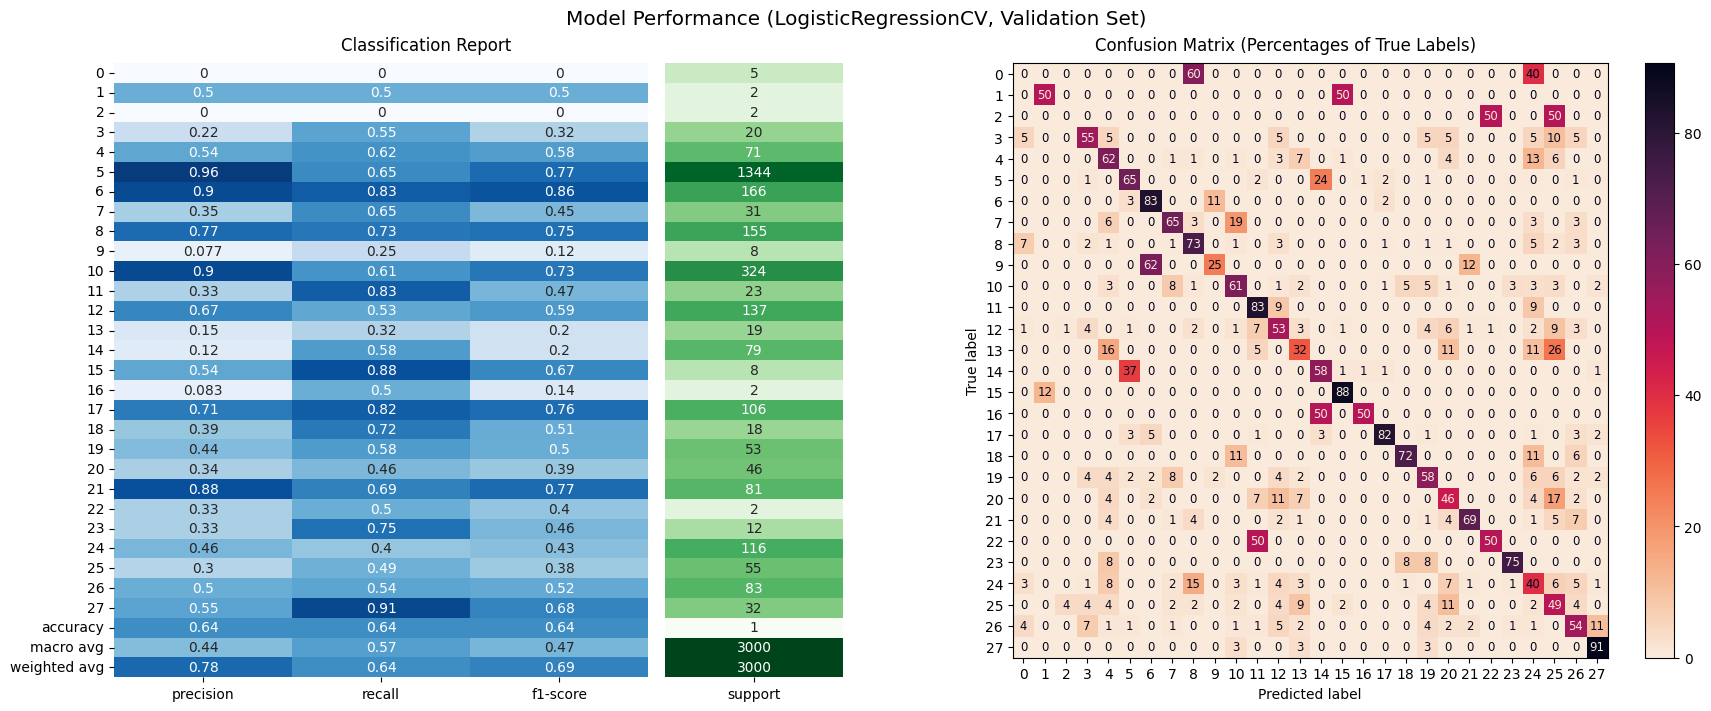

In [ ]:
# Predict on the validation set
y_pred_val = lr_cv_pipe.predict(X_val)
y_proba_val = lr_cv_pipe.predict_proba(X_val)
print("Weighted log-loss on validation set:", weighted_log_loss(y_val, y_proba_val))

plot_metrics(y_val, y_pred_val, "LogisticRegressionCV, Validation Set")

Weighted log-loss on test set 2: 0.016492161433618122


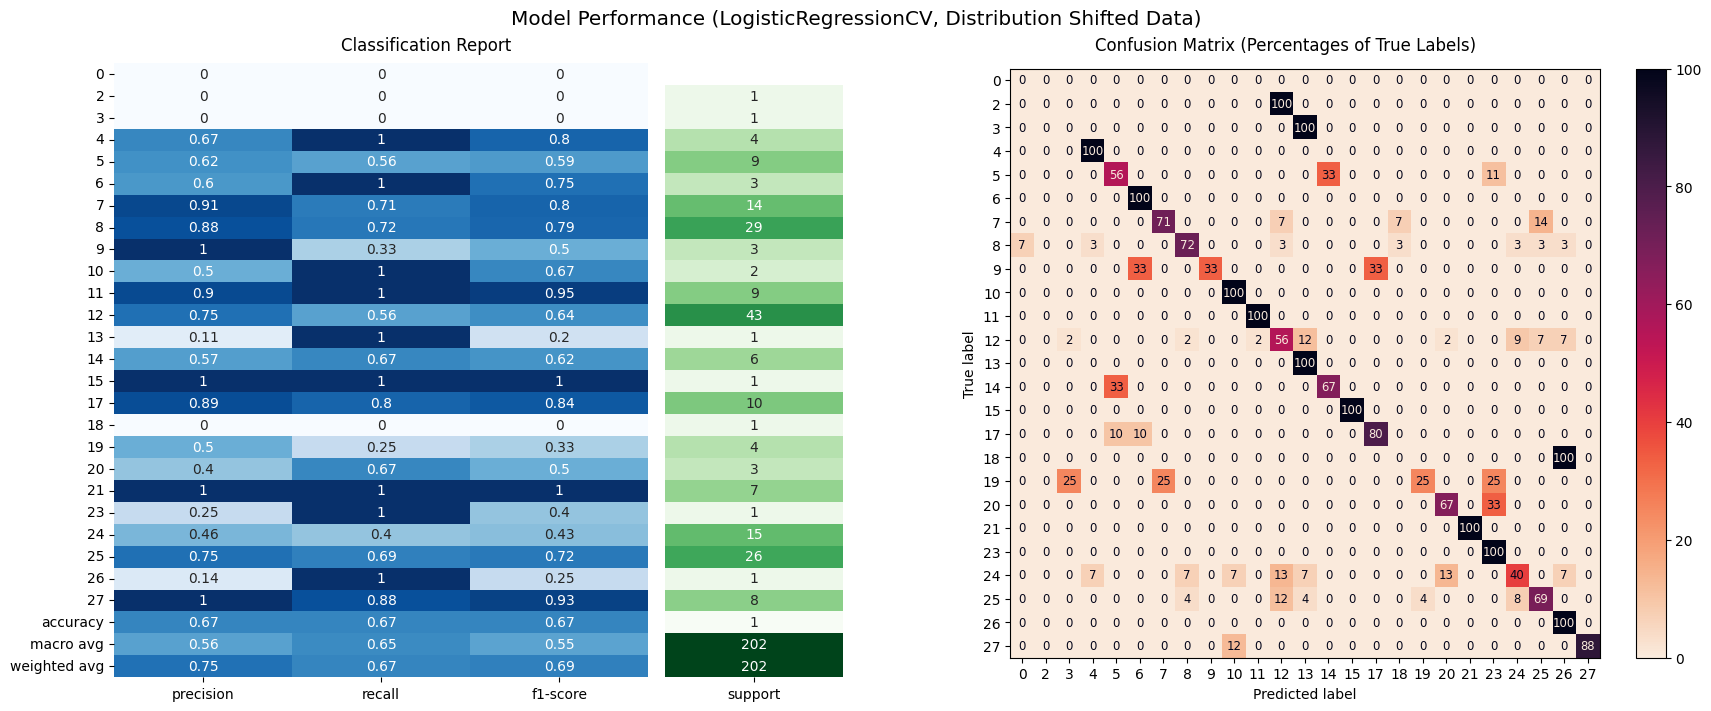

In [ ]:
# Predict on the labelled portion of test set 2 (post-distribution shift)
y_pred_shifted = lr_cv_pipe.predict(X_test_2_labelled)
y_proba_shifted = lr_cv_pipe.predict_proba(X_test_2_labelled)
print("Weighted log-loss on test set 2:", weighted_log_loss(y_test_2_labelled, y_proba_shifted))

plot_metrics(y_test_2_labelled, y_pred_shifted, "LogisticRegressionCV, Distribution Shifted Data")